In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [73]:
# Cancer data
s2_samples = pd.read_csv('../data/cancer/stage_2_prostate_cancer_samples.csv')
s2_samples.head(2)
s2_samples.shape

(395, 2570)

In [74]:
s3_samples = pd.read_csv('../data/cancer/stage_3_prostate_cancer_samples.csv')
s3_samples.head(2)
s3_samples.shape

(150, 2570)

In [75]:
# Combine stage 1 and stage 2 samples
combined_dataset = pd.concat([s2_samples, s3_samples], ignore_index=True)

# Verify the Stage column exists and print unique values
print("Unique values in Stage column:", combined_dataset['Stage'].unique())

# Strip the "Stage: " prefix from the Stage column and then label the samples
combined_dataset['Stage'] = combined_dataset['Stage'].str.strip()

# Label the samples (0 for stage 1, 1 for stage 2)
combined_dataset['ID_REF'] = np.where(combined_dataset['Stage'] == 'Stage: 2', 0, 1)
combined_dataset['ID_REF'] = np.where(combined_dataset['Stage'] == 'Stage: 3', 1, combined_dataset['ID_REF'])

# Print class distribution to ensure both classes are present
print("Class distribution in ID_REF column:")
print(combined_dataset['ID_REF'].value_counts()) 

Unique values in Stage column: ['Stage: 2' 'Stage: 3']
Class distribution in ID_REF column:
ID_REF
0    395
1    150
Name: count, dtype: int64


In [76]:
def process_data(data, under_sample_factor=None, over_sample_factor=None):
    # Drop metadata columns
    columns_to_drop = ['Sample_ID', 'Sex', 'Age', 'Stage', 'Disease']
    data = data.drop(columns=columns_to_drop, axis=1)
    
    x = np.array(data.drop(["ID_REF"], axis=1)).astype('float')
    y = np.array(data["ID_REF"]).astype('int')
    feature_names = data.columns[1:]

    if under_sample_factor is not None and isinstance(under_sample_factor, float) and 0 < under_sample_factor <= 1:
        under_sampler = RandomUnderSampler(sampling_strategy=under_sample_factor)
        x, y = under_sampler.fit_resample(x, y)

    if over_sample_factor is not None and isinstance(over_sample_factor, float) and 0 < over_sample_factor <= 1:
        over_sampler = RandomOverSampler(sampling_strategy=over_sample_factor)
        x, y = over_sampler.fit_resample(x, y)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

    # Normalization
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test, feature_names

In [77]:
# Support Vector Machine model
def support_vector_machine(x_train, y_train, feature_num):
    pipe = Pipeline([('skb', SelectKBest(f_classif, k=feature_num)), ('estimator', SVC(probability=True))])

    pipe_parameters = {'skb__k': [feature_num],
                       'estimator__C': [0.25, 0.5, 0.75, 1],
                       'estimator__kernel': ['linear']}

    svm_grid_search = GridSearchCV(pipe, pipe_parameters, scoring='accuracy', cv=StratifiedKFold(10), n_jobs=-1)
    svm_grid_search.fit(x_train, y_train)

    return svm_grid_search

In [78]:
# Get SVM metrics
def get_svm_metrics(svm_grid_search, x_test, y_test):
    best_accuracy = svm_grid_search.best_score_
    best_parameters = svm_grid_search.best_params_
    print("Training Accuracy:", best_accuracy)
    print("Best Parameters:", best_parameters)

    y_pred = svm_grid_search.predict(x_test)
    
    if hasattr(svm_grid_search.best_estimator_.named_steps['estimator'], 'predict_proba'):
        y_pred_proba = svm_grid_search.predict_proba(x_test)[:, 1]
        print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label="SVM (area = {:.2f})".format(roc_auc_score(y_test, y_pred_proba)))
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="best")
        plt.show()
    else:
        y_pred_proba = None

    print("Testing Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

In [79]:
# Get top SVM features
def get_top_svm_features(svm_grid_search, feature_names, top_feature_num):
    coef_list = svm_grid_search.best_estimator_.named_steps['estimator'].coef_[0]
    features = svm_grid_search.best_estimator_.named_steps['skb'].get_support()
    selected_features_list = feature_names[features].tolist()

    coef_list, selected_features_list = zip(*sorted(zip(abs(coef_list), selected_features_list), reverse=True))
    coef_list, selected_features_list = list(coef_list), list(selected_features_list)

    return coef_list[:top_feature_num], selected_features_list[:top_feature_num]

In [80]:
# Random Forest model
def random_forest(x_train, y_train, feature_num):
    pipe = Pipeline([('skb', SelectKBest(f_classif, k=feature_num)), ('estimator', RandomForestClassifier(random_state=0))])

    pipe_parameters = {'skb__k': [feature_num],
                       'estimator__n_estimators': [100, 500],
                       'estimator__max_features': ['sqrt', 'log2'],
                       'estimator__criterion': ['gini', 'entropy']}

    rf_grid_search = GridSearchCV(pipe, pipe_parameters, scoring='accuracy', cv=StratifiedKFold(10), n_jobs=-1)
    rf_grid_search.fit(x_train, y_train)

    return rf_grid_search

In [81]:
# Get Random Forest metrics
def get_rf_metrics(rf_grid_search, x_test, y_test):
    best_accuracy = rf_grid_search.best_score_
    best_parameters = rf_grid_search.best_params_
    print("Training Accuracy:", best_accuracy)
    print("Best Parameters:", best_parameters)

    y_pred = rf_grid_search.predict(x_test)
    y_pred_proba = rf_grid_search.predict_proba(x_test)[:, 1]

    print("Testing Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label="RF (area = {:.2f})".format(roc_auc_score(y_test, y_pred_proba)))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

In [82]:
# Get top Random Forest features
def get_top_rf_features(rf_grid_search, feature_names, top_feature_num):
    importance_list = rf_grid_search.best_estimator_.named_steps['estimator'].feature_importances_
    features = rf_grid_search.best_estimator_.named_steps['skb'].get_support()
    selected_features_list = feature_names[features].tolist()

    importance_list, selected_features_list = zip(*sorted(zip(importance_list, selected_features_list), reverse=True))
    importance_list, selected_features_list = list(importance_list), list(selected_features_list)

    return importance_list[:top_feature_num], selected_features_list[:top_feature_num]

In [83]:
# Gradient Boosting model
def gradient_boosting(x_train, y_train, feature_num):
    pipe = Pipeline([('skb', SelectKBest(f_classif, k=feature_num)), ('estimator', GradientBoostingClassifier())])

    pipe_parameters = {'skb__k': [feature_num],
                       'estimator__learning_rate': [0.5, 1],
                       'estimator__n_estimators': [50]}

    gb_grid_search = GridSearchCV(pipe, pipe_parameters, scoring='accuracy', cv=StratifiedKFold(10), n_jobs=-1)
    gb_grid_search.fit(x_train, y_train)

    return gb_grid_search

In [84]:
# Get Gradient Boosting metrics
def get_gb_metrics(gb_grid_search, x_test, y_test):
    best_accuracy = gb_grid_search.best_score_
    best_parameters = gb_grid_search.best_params_
    print("Training Accuracy:", best_accuracy)
    print("Best Parameters:", best_parameters)

    y_pred = gb_grid_search.predict(x_test)
    y_pred_proba = gb_grid_search.predict_proba(x_test)[:, 1]

    print("Testing Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label="GB (area = {:.2f})".format(roc_auc_score(y_test, y_pred_proba)))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

In [85]:
# Get top Gradient Boosting features
def get_top_gb_features(gb_grid_search, feature_names, top_feature_num):
    importance_list = gb_grid_search.best_estimator_.named_steps['estimator'].feature_importances_
    features = gb_grid_search.best_estimator_.named_steps['skb'].get_support()
    selected_features_list = feature_names[features].tolist()

    importance_list, selected_features_list = zip(*sorted(zip(importance_list, selected_features_list), reverse=True))
    importance_list, selected_features_list = list(importance_list), list(selected_features_list)

    return importance_list[:top_feature_num], selected_features_list[:top_feature_num]

In [86]:
def get_top_features(svm_top_features, rf_top_features, gb_top_features, top_feature_num):
    features_list_full = []
    # features_list_full.extend(svm_top_features)
    features_list_full.extend(rf_top_features)
    features_list_full.extend(gb_top_features)
    features_list = list(dict.fromkeys(features_list_full))

    rank_features_list = []
    rank_num_list = []

    for feature in features_list:
        # Check if feature is in each list, use high index if not present to avoid skewing the rank
        # svm_index = svm_top_features.index(feature) if feature in svm_top_features else len(svm_top_features)
        rf_index = rf_top_features.index(feature) if feature in rf_top_features else len(rf_top_features)
        gb_index = gb_top_features.index(feature) if feature in gb_top_features else len(gb_top_features)

        # rank = float(svm_index + rf_index + gb_index) / 3
        rank = float(rf_index + gb_index) / 2
        rank_features_list.append(feature)
        rank_num_list.append(rank)

    rank_num_list, rank_features_list = zip(*sorted(zip(rank_num_list, rank_features_list)))

    rank_features_list = rank_features_list[:top_feature_num]

    return rank_features_list

In [87]:
# Analysis
def create_network(top_features_list, all_features_list, correlation_threshold_factor, cancer_dataset):
    cancer_subset, control_subset = cancer_dataset[(cancer_dataset["ID_REF"] == 0)], cancer_dataset[(cancer_dataset["ID_REF"] == 1)]

    edges = [((node1, node2), cancer_subset[node1].corr(cancer_subset[node2], method="pearson")) for node1, node2 in itertools.combinations(top_features_list, 2)]
    edges = [(node1, node2, {'weight': abs(correlation), 'sign': 1 if correlation > 0 else 0}) for (node1, node2), correlation in edges if abs(correlation) >= correlation_threshold_factor]

    nodes = [(feature, {'sides': all_features_list.count(feature) + 1, "comparison": 1 if cancer_subset[feature].mean() >= control_subset[feature].mean() else (0 if cancer_subset[feature].mean() < control_subset[feature].mean() else 0.5)}) for feature in top_features_list]

    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    degrees = dict(graph.degree())
    network_degrees_values, network_degrees_nodes = zip(*sorted(zip(degrees.values(), degrees.keys()), reverse=True))
    print(network_degrees_nodes)
    print(network_degrees_values)

    return graph

In [88]:
import os

def create_bar_charts(top_features_list, full_dataset, path_name):
    prostate_cancer = full_dataset[(full_dataset["ID_REF"] == 0)]
    no_cancer = full_dataset[(full_dataset["ID_REF"] == 1)]

    cancer_dataset = [prostate_cancer, no_cancer]

    # Create directories if they don't exist
    base_path = "../bar_charts"
    full_path = os.path.join(base_path, path_name)
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    plt.ioff()
    for feature_name in top_features_list:
        plt.figure(0).clf()
        plt.figure(figsize=(9, 6))

        plt.rcParams.update({'font.size': 18})

        labels = ['Prostate Cancer', 'No Cancer']
        means = [data[feature_name].mean() for data in cancer_dataset]
        errors = [data[feature_name].sem() * 2 for data in cancer_dataset]
        plt.bar(labels, means, yerr=errors, error_kw={'elinewidth': 10, 'ecolor': 'k'}, capsize=15)

        plt.title(feature_name)
        plt.ylabel('Signal Value')
        plt.savefig(os.path.join(full_path, f"{feature_name}.png"), dpi=200, bbox_inches='tight')
    plt.ion()

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from sklearn.inspection import permutation_importance
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the Keras model
def keras_model(x_train, y_train, x_test, y_test):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

    results = model.evaluate(x_test, y_test, verbose=0)
    print(f"Keras Model Test Loss: {results[0]}")
    print(f"Keras Model Test Accuracy: {results[1]}")

    y_pred = model.predict(x_test).ravel()
    y_pred_classes = (y_pred > 0.5).astype(int)

    print(classification_report(y_test, y_pred_classes))

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Keras Model ROC AUC: {roc_auc}")

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    print("Keras Model Confusion Matrix:")
    print(conf_matrix)

    return model, results[1], roc_auc, conf_matrix

In [90]:
# Perform cross-validation function
def perform_cross_validation(model, x_train, y_train):
    cv_scores = cross_val_score(model.best_estimator_, x_train, y_train, cv=StratifiedKFold(10))
    print("Cross-Validation Scores:", cv_scores)
    print("Mean Cross-Validation Score:", np.mean(cv_scores))

In [91]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### SVM Model ###
Training Accuracy: 0.6516384778012685
Best Parameters: {'estimator__C': 0.25, 'estimator__kernel': 'linear', 'skb__k': 500}
ROC AUC Score: 0.6746835443037975


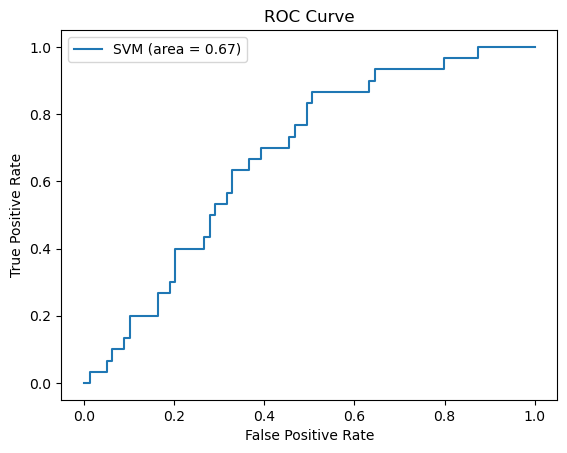

Testing Accuracy: 0.6880733944954128
Precision: 0.42857142857142855
Recall: 0.4
F1 Score: 0.41379310344827586
Confusion Matrix:
[[63 16]
 [18 12]]
Cross-Validation Scores: [0.65909091 0.61363636 0.75       0.5        0.59090909 0.68181818
 0.62790698 0.65116279 0.76744186 0.6744186 ]
Mean Cross-Validation Score: 0.6516384778012685


### Random Forest Model ###
Training Accuracy: 0.7270084566596194
Best Parameters: {'estimator__criterion': 'entropy', 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 500, 'skb__k': 500}
Testing Accuracy: 0.7155963302752294
Precision: 0.3333333333333333
Recall: 0.03333333333333333
F1 Score: 0.06060606060606061
ROC AUC Score: 0.658860759493671
Confusion Matrix:
[[77  2]
 [29  1]]


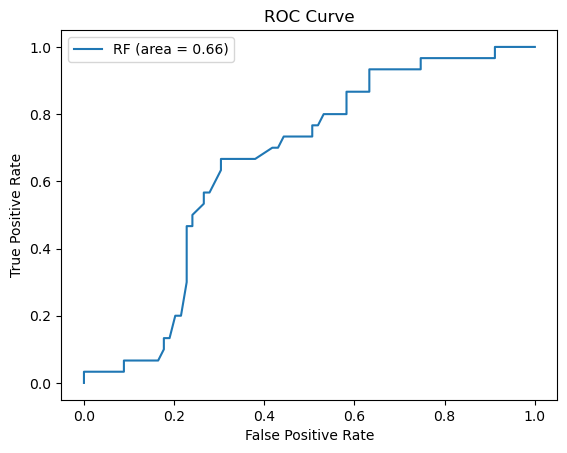

Cross-Validation Scores: [0.72727273 0.72727273 0.72727273 0.70454545 0.77272727 0.72727273
 0.72093023 0.72093023 0.72093023 0.72093023]
Mean Cross-Validation Score: 0.7270084566596194


### Gradient Boosting Model ###
Training Accuracy: 0.6838794926004228
Best Parameters: {'estimator__learning_rate': 1, 'estimator__n_estimators': 50, 'skb__k': 500}
Testing Accuracy: 0.6697247706422018
Precision: 0.35
Recall: 0.23333333333333334
F1 Score: 0.28
ROC AUC Score: 0.5683544303797468
Confusion Matrix:
[[66 13]
 [23  7]]


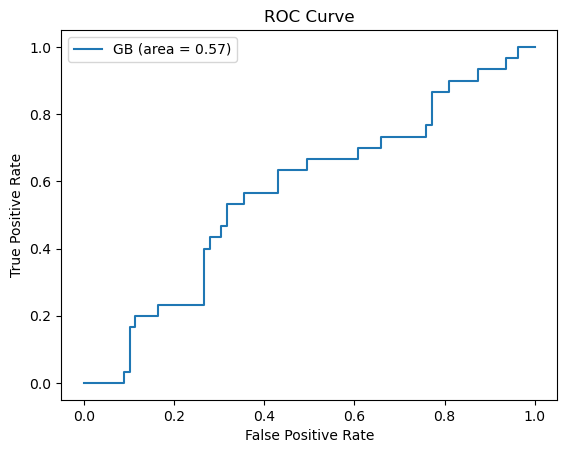

Cross-Validation Scores: [0.59090909 0.72727273 0.61363636 0.61363636 0.68181818 0.61363636
 0.69767442 0.72093023 0.72093023 0.76744186]
Mean Cross-Validation Score: 0.6747885835095137


### Keras Model ###


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Keras Model Test Loss: 0.6347594857215881
Keras Model Test Accuracy: 0.6880733966827393
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        79
           1       0.38      0.20      0.26        30

    accuracy                           0.69       109
   macro avg       0.56      0.54      0.53       109
weighted avg       0.64      0.69      0.65       109

Keras Model ROC AUC: 0.5354430379746835


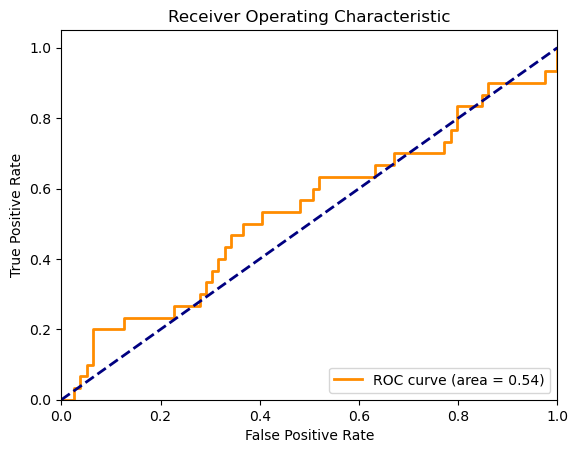

Keras Model Confusion Matrix:
[[69 10]
 [24  6]]
Keras Model Test Accuracy: 0.6880733966827393
Keras Model ROC AUC: 0.5354430379746835


### Top Features Across SVM, RF, and XGBoost Models ###
('hsa-miR-6722-3p', 'hsa-miR-3130-3p', 'hsa-miR-4749-5p', 'hsa-miR-3935', 'hsa-miR-146a-3p', 'hsa-miR-3617-3p', 'hsa-miR-5587-5p', 'hsa-miR-660-5p', 'hsa-miR-8082', 'hsa-miR-3664-3p', 'hsa-miR-1229-3p', 'hsa-miR-320b', 'hsa-miR-6847-3p', 'hsa-miR-412-5p', 'hsa-miR-6854-3p', 'hsa-miR-96-5p', 'hsa-miR-875-5p', 'hsa-miR-1257', 'hsa-miR-6827-3p', 'hsa-miR-183-3p') 20


In [92]:
# Define parameters
feature_selection_num = 500
feature_importance_num = 20

# Process data
x_train_nc, x_test_nc, y_train_nc, y_test_nc, feature_names_nc = process_data(combined_dataset, under_sample_factor=None, over_sample_factor=None)

# Train and evaluate SVM model
print("### SVM Model ###")
svm_grid_search = support_vector_machine(x_train_nc, y_train_nc, feature_selection_num)
get_svm_metrics(svm_grid_search, x_test_nc, y_test_nc)
svm_top_coef, svm_top_features = get_top_svm_features(svm_grid_search, feature_names_nc, feature_importance_num)
perform_cross_validation(svm_grid_search, x_train_nc, y_train_nc)
print("\n")

# Train and evaluate Random Forest model
print("### Random Forest Model ###")
rf_grid_search = random_forest(x_train_nc, y_train_nc, feature_selection_num)
get_rf_metrics(rf_grid_search, x_test_nc, y_test_nc)
rf_top_importance, rf_top_features = get_top_rf_features(rf_grid_search, feature_names_nc, feature_importance_num)
perform_cross_validation(rf_grid_search, x_train_nc, y_train_nc)
print("\n")

# Train and evaluate Gradient Boosting model
print("### Gradient Boosting Model ###")
gb_grid_search = gradient_boosting(x_train_nc, y_train_nc, feature_selection_num)
get_gb_metrics(gb_grid_search, x_test_nc, y_test_nc)
gb_top_importance, gb_top_features = get_top_gb_features(gb_grid_search, feature_names_nc, feature_importance_num)
perform_cross_validation(gb_grid_search, x_train_nc, y_train_nc)
print("\n")

# Train and evaluate Keras model
print("### Keras Model ###")
keras_trained_model, keras_test_accuracy, keras_roc_auc, keras_conf_matrix = keras_model(x_train_nc, y_train_nc, x_test_nc, y_test_nc)
print(f"Keras Model Test Accuracy: {keras_test_accuracy}")
print(f"Keras Model ROC AUC: {keras_roc_auc}")
# print("Keras Model Confusion Matrix:")
# print(keras_conf_matrix)
print("\n")

# Get top features across SVM, RF, and XGBoost
print("### Top Features Across SVM, RF, and XGBoost Models ###")
top_features = get_top_features(svm_top_features, rf_top_features, gb_top_features, feature_importance_num)
print(top_features, len(top_features))


# # Analysis and visualization
# network_graph = create_network(top_features, list(feature_names_nc), correlation_threshold_factor=0.5, cancer_dataset=combined_dataset)
# create_bar_charts(top_features, combined_dataset, path_name="Feature_Bar_Charts")

# # Plot learning curve for the best SVM model
# print("### SVM Learning Curve ###")
# plot_learning_curve(svm_grid_search.best_estimator_, "Learning Curve (SVM)", x_train_nc, y_train_nc, cv=StratifiedKFold(10))
# plt.show()

In [93]:
# Output top features as a list with no quotes, comma separated
print(", ".join(top_features))

hsa-miR-6722-3p, hsa-miR-3130-3p, hsa-miR-4749-5p, hsa-miR-3935, hsa-miR-146a-3p, hsa-miR-3617-3p, hsa-miR-5587-5p, hsa-miR-660-5p, hsa-miR-8082, hsa-miR-3664-3p, hsa-miR-1229-3p, hsa-miR-320b, hsa-miR-6847-3p, hsa-miR-412-5p, hsa-miR-6854-3p, hsa-miR-96-5p, hsa-miR-875-5p, hsa-miR-1257, hsa-miR-6827-3p, hsa-miR-183-3p


In [94]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam  # Use Adam optimizer
# from tensorflow.keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt
# from sklearn.inspection import permutation_importance

# # Assuming combined_dataset is your DataFrame
# # Drop the 'Sample_ID' column and separate features and target
# X = combined_dataset.drop(columns=['Sample_ID', 'ID_REF'])
# y = combined_dataset['ID_REF']

# # Convert categorical columns to dummy variables
# X = pd.get_dummies(X, columns=['Sex', 'Stage', 'Age', 'Disease'], drop_first=True)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Define the model
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model with Adam optimizer
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model
# history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

# # Evaluate the model
# results = model.evaluate(X_test, y_test, verbose=0)
# print(f"Keras Model Test Loss: {results[0]}")
# print(f"Keras Model Test Accuracy: {results[1]}")

# # Predict on the test data
# y_pred = model.predict(X_test).ravel()
# y_pred_classes = (y_pred > 0.5).astype(int)

# # Generate and print classification report
# print(classification_report(y_test, y_pred_classes))

# # Compute and print ROC AUC
# roc_auc = roc_auc_score(y_test, y_pred)
# print(f"Keras Model ROC AUC: {roc_auc}")

# # Plot ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# # Confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)
# print("Keras Model Confusion Matrix:")
# print(conf_matrix)

# # Define the wrapper class
# class KerasModelWrapper:
#     def __init__(self, model):
#         self.model = model
    
#     def fit(self, X, y):
#         self.model.fit(X, y, epochs=10, verbose=0)
    
#     def predict(self, X):
#         return self.model.predict(X).ravel()
    
#     def score(self, X, y):
#         y_pred = self.predict(X)
#         y_pred_classes = (y_pred > 0.5).astype(int)
#         return np.mean(y_pred_classes == y)

# # Wrap the Keras model
# wrapped_model = KerasModelWrapper(model)

# # Compute permutation importance
# result = permutation_importance(wrapped_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# importance_scores = result.importances_mean
# sorted_idx = importance_scores.argsort()

# # Plot feature importances
# plt.figure()
# plt.barh(range(len(sorted_idx)), importance_scores[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
# plt.xlabel("Permutation Importance")
# plt.title("Feature Importance in Keras Model")
# plt.show()